In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faldi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('train.csv')
df.head(15)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [4]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
df.shape

(404290, 6)

In [6]:
df.dropna(axis=0, inplace=True)

In [7]:
df.shape

(404287, 6)

In [8]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

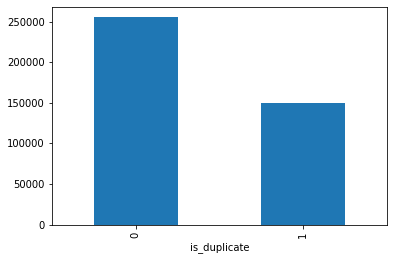

In [9]:
df.groupby("is_duplicate")["id"].count().plot.bar()

In [10]:
df.drop(['id','qid1','qid2'], axis=1, inplace=True)

In [11]:
df.shape

(404287, 3)

In [12]:
a=0
for i in range(a,a+15):
    print(df.question1[i])
    print(df.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

In [13]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    stops = set(stopwords.words("english"))
    # Membersihkan text dengan stemming word
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Membersihkan text / Stemming Word
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # menghapus koma
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    
    # tambahkan padding ke tanda baca dan karakter khusus
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # mereplace non asci menjadi asci
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # membersihkan text rules yang didapat dari url : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # mereplace float number menjadi random number
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # menghapus padding dari text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # mengembalikan semua list kata yang telat di stemming
    return text

In [14]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)


In [15]:
X = df.loc[:, df.columns != 'is_duplicate']
y = df.loc[:, df.columns == 'is_duplicate']

In [16]:
a=0
for i in range(a,a+15):
    print(df.question1[i])
    print(df.question2[i])
    print()

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what is the story of kohinoor kohinoor diamond
what would happen if the indian government stole the kohinoor kohinoor diamond back

how can i increase the speed of my internet connection while using a vpn
how can internet speed be increased by hacking through dns

why am i mentally very lonely how can i solve it
find the remainder when math2324math is divided by 2423

which one dissolve in water quikly sugar salt methane and carbon di oxide
which fish would survive in salt water

astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me

should i buy tiago
what keeps childern active and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use  nonasciiword  instead of  nonasciiword 
when do y

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [18]:
transformer = FeatureUnion([
                ('question1_bow', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['question1'], 
                                                  validate=False)),
                            ('bow', 
                              CountVectorizer())])),
                ('question2_bow', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['question2'], 
                                                  validate=False)),
                            ('bow', 
                              CountVectorizer())]))])

In [19]:
X_train_count = transformer.fit_transform(X_train)
X_train_count.shape

(283000, 128314)

In [20]:
rf = RandomForestClassifier().fit(X_train_count, y_train.values.ravel())
X_test_count = transformer.transform(X_test)
y_pred = rf.predict(X_test_count)
print(metrics.classification_report(y_test, y_pred))

C:\Users\Faldi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.92      0.85     76647
           1       0.80      0.57      0.66     44640

    accuracy                           0.79    121287
   macro avg       0.79      0.74      0.76    121287
weighted avg       0.79      0.79      0.78    121287



In [21]:
logreg = LogisticRegression().fit(X_train_count, y_train.values.ravel())
X_test_count = transformer.transform(X_test)
y_pred = logreg.predict(X_test_count)
print(metrics.classification_report(y_test, y_pred))

C:\Users\Faldi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.79      0.83      0.81     76647
           1       0.68      0.61      0.65     44640

    accuracy                           0.75    121287
   macro avg       0.73      0.72      0.73    121287
weighted avg       0.75      0.75      0.75    121287



In [22]:
tfidf_trfm = TfidfTransformer(norm=None)
X_train_count_tfidf = tfidf_trfm.fit_transform(X_train_count)
X_test_count_tfidf = tfidf_trfm.transform(X_test_count)
y_pred = rf.predict(X_test_count_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.93      0.83     76647
           1       0.80      0.44      0.57     44640

    accuracy                           0.75    121287
   macro avg       0.77      0.69      0.70    121287
weighted avg       0.76      0.75      0.73    121287



In [23]:
transformer = FeatureUnion([
                ('question1_tfidf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['question1'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('question2_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['question2'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())]))])

In [24]:
X_train_tfidf = transformer.fit_transform(X_train)
X_test_tfidf = transformer.transform(X_test)

In [25]:
X_train_tfidf.shape

(283000, 128314)

In [ ]:
def randomforest_classify(X_tr, y_tr, X_test, y_test, description):
    ### Helper function to train a random forest classifier and score on test data
    m = RandomForestClassifier().fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

m_bow = randomforest_classify(X_train_count, y_train.values.ravel(), X_test_count, y_test.values.ravel(), 'bow')
m_tfidf = randomforest_classify(X_train_tfidf, y_train.values.ravel(), X_test_tfidf, y_test.values.ravel(), 'tf-idf')

C:\Users\Faldi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test score with bow features: 0.7884109591299975


C:\Users\Faldi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
rf = RandomForestClassifier().fit(X_train_tfidf, y_train.values.ravel())
X_test_tfidf = transformer.transform(X_test)
y_pred = rf.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred))